## Decision Tree and Random Forest Comparison

- Determine if kickstarter project will be successfully funded or not.
- Compare execution speeds of the two methods.

### A. Data Cleaning

In [1]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

In [2]:
# Open file.
df = pd.read_csv('ks-projects-201801.csv')
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01 03:43:57,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0


In [3]:
# Create features.

df.loc[:,'goal_reached'] = df['pledged'] / df['goal'] # Pledged amount as a percentage of goal.

df.loc[df['backers'] == 0, 'backers'] = 1 # Convert zero backers to 1 to prevent undefined division.
df.loc[:,'pledge_per_backer'] = df['pledged'] / df['backers'] # Pledged amount per backer.

# Create the subset.
df_sub = df[['category', 'main_category', 'goal_reached', 'pledge_per_backer', 'state', 'country']]

In [4]:
# Check shape and data types.
print(df_sub.shape)
print('\n')
print(df_sub.dtypes)

(378661, 6)


category              object
main_category         object
goal_reached         float64
pledge_per_backer    float64
state                 object
country               object
dtype: object


In [5]:
# Check for nulls.
df_sub.isnull().sum()

category             0
main_category        0
goal_reached         0
pledge_per_backer    0
state                0
country              0
dtype: int64

In [6]:
# Code the goal_reached and pledge_per_backer features as 0 or 1.
df_sub['goal_reached_cat'] = np.where(df_sub['goal_reached']>0.5, 1, 0)
df_sub['pledge_per_backer_cat'] = np.where(df_sub['pledge_per_backer']>df_sub['pledge_per_backer'].mean(), 1, 0)

# Create the final subset of features that will be used to predict if a kickstarter project will be successfully funded.
df_final = df_sub[['category', 'main_category', 'goal_reached_cat', 'pledge_per_backer_cat', 'state', 'country']]

### B. Decision Tree

In [41]:
# Set variables.
X = df_final.drop(['state'], axis=1)
X = pd.get_dummies(X)
y = df_final['state']

# Set the start time for execution speed.
import time
start_time = time.clock() 

# Split into train and test sets.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Fit the model.
from sklearn import tree
dtc = tree.DecisionTreeClassifier(criterion='entropy', max_features=3, max_depth=4, random_state = 1337)
dtc.fit(X_train, y_train)

# Run predictions.
y_predict = dtc.predict(X_test)

# Return accuracy score.
from sklearn.metrics import accuracy_score
print('Score:', accuracy_score(y_test, y_predict))
print('Runtime: '+'%s seconds'% (time.clock() - start_time)) # End time for execution speed.

Score: 0.542258294527
Runtime: 1.7144401158461733 seconds


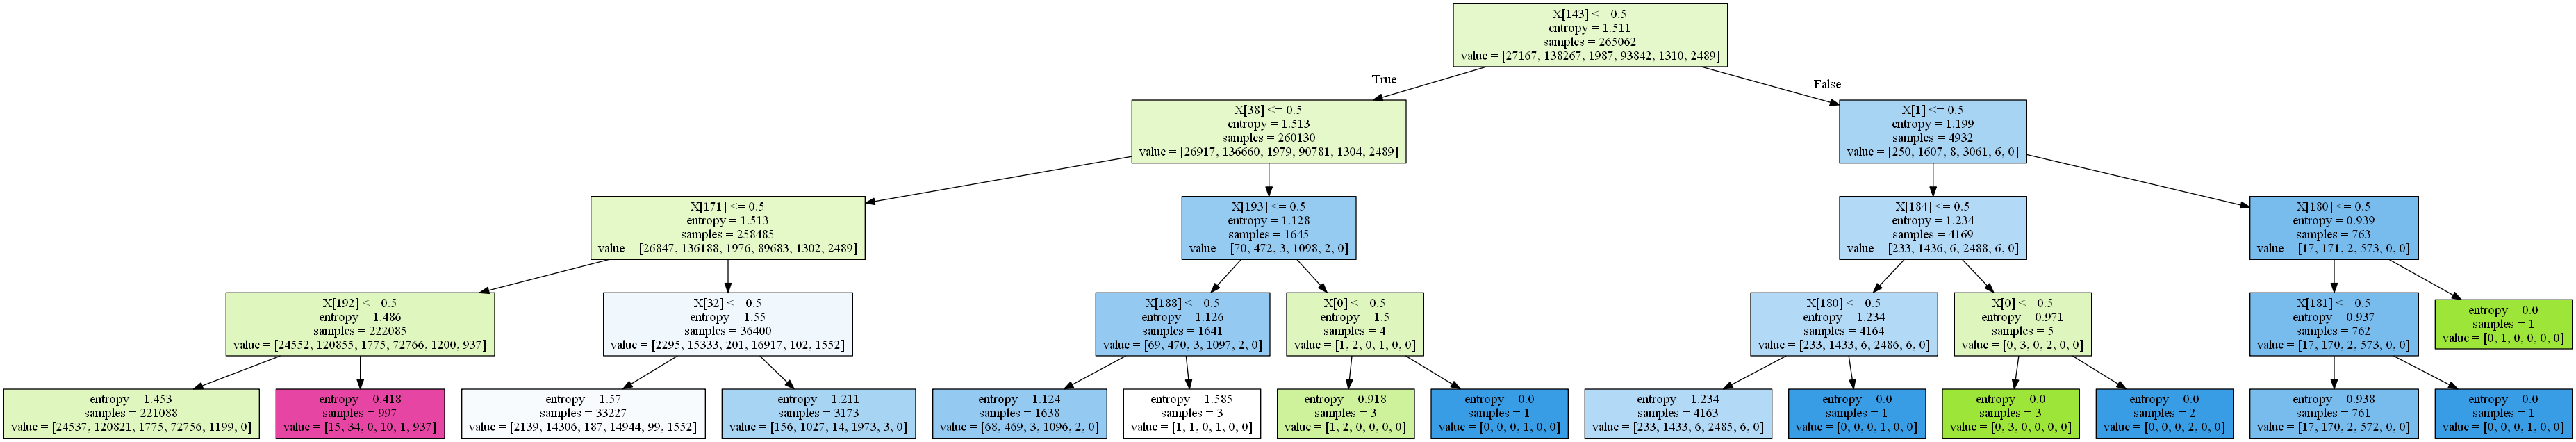

In [48]:
from IPython.display import Image
import pydotplus
import graphviz

dot_data = tree.export_graphviz(dtc, out_file=None, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

### C. Random Forest

In [10]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

start_time = time.clock() # Start time.
rfc = ensemble.RandomForestClassifier()
print('Scores: ', cross_val_score(rfc, X, y, cv=10)) # Return cross validation scores.
print('Runtime: '+'%s seconds'% (time.clock() - start_time)) # End time.

Scores:  [ 0.8644502   0.86452942  0.86426176  0.86515964  0.86460507  0.86513323
  0.86451868  0.86575994  0.86496765  0.86411177]
Runtime: 201.31617155530566 seconds


Random forest was more accurate than the decision tree but at a significantly higher computation cost.